# Correct FWHM (and Contrast) time series for Earth eccentricity effects

Suzanne Aigrain @ Oxford, July 2019

In [1]:
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


Read in data

[2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015
 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015
 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015
 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015
 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015
 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 2016
 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016
 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016
 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016
 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016
 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016
 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016
 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016
 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 2016
 2016 

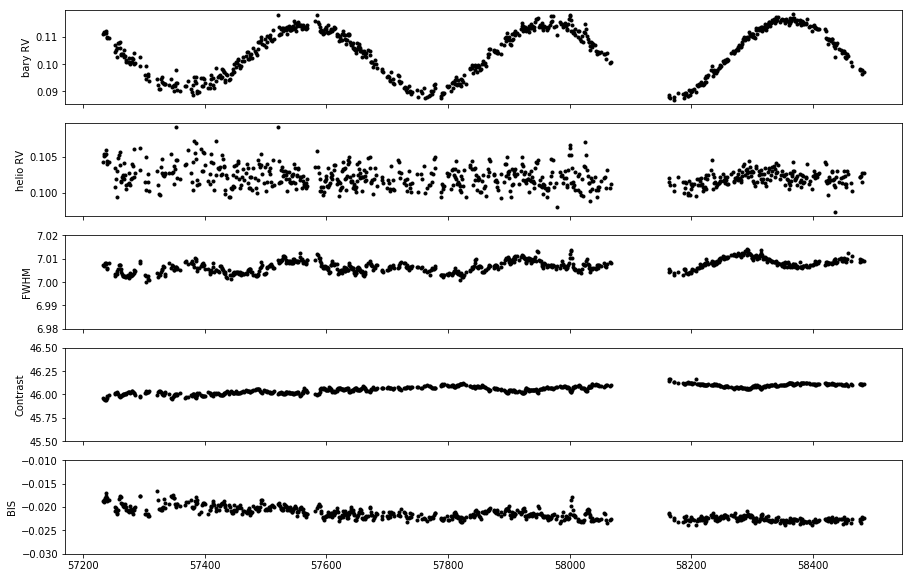

In [13]:
years = ['2015','2016','2017','2018']
for i, year in enumerate(years):
    with open('../data/HARPN_Sun/vel_'+year,'rb') as infile:
        velYear = pickle.load(infile)
    if i == 0:
        bjd = velYear[:,0]
        rvh = velYear[:,1]
        bsrv = velYear[:,2]
        fwhm = velYear[:,3]
        cont = velYear[:,4]
        bis = velYear[:,5]
        yr = np.zeros_like(bjd).astype('int') + int(year)
    else:
        bjd = np.concatenate([bjd,velYear[:,0]]).flatten()
        rvh = np.concatenate([rvh,velYear[:,1]]).flatten()
        bsrv = np.concatenate([bsrv,velYear[:,2]]).flatten()
        fwhm = np.concatenate([fwhm,velYear[:,3]]).flatten()
        cont = np.concatenate([cont,velYear[:,4]]).flatten()
        bis = np.concatenate([bis,velYear[:,5]]).flatten()
        yy = np.zeros_like(velYear[:,0]).astype('int') + int(year)
        yr = np.concatenate([yr,yy]).flatten()
rvb = rvh - bsrv
fig, axes = plt.subplots(5,1,figsize=(15,10),sharex=True)
axes[0].plot(bjd,rvb,'k.')
axes[1].plot(bjd,rvh,'k.')
axes[2].plot(bjd,fwhm,'k.')
axes[3].plot(bjd,cont,'k.')
axes[4].plot(bjd,bis,'k.')
axes[0].set_ylabel('bary RV')
axes[1].set_ylabel('helio RV')
axes[2].set_ylabel('FWHM')
axes[2].set_ylim(6.98,7.02)
axes[3].set_ylabel('Contrast')
axes[3].set_ylim(45.5,46.5)
axes[4].set_ylabel('BIS')
axes[4].set_ylim(-0.03,-0.01);
#plt.xlim(57580,57730)
print(yr)

[-4.21121437e-04  1.27579425e-03 -2.04015419e-03 -9.54830828e-05
 -1.62409947e-03  2.65106357e-06]
[ 1.35721782e-03 -1.11781349e-02  1.58026383e-02 -8.48255196e-04
 -6.29346369e-02  9.69201752e-05]


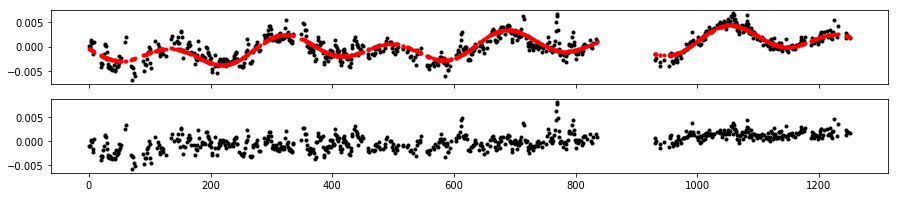

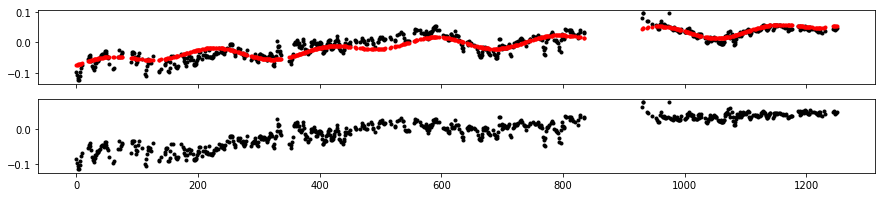

In [14]:
from scipy.optimize import minimize
def ecc_model(coeffs, x):
    per = 365.2422
    return coeffs[0] * np.sin(2 * np.pi * x / per) + coeffs[1] * np.cos(2 * np.pi * x / per) +  coeffs[2] * np.sin(4 * np.pi * x / per) + coeffs[3] * np.cos(4 * np.pi * x / per) + coeffs[4] + coeffs[5] * x
def ecc_errfunct(coeffs, x, y):
    m = ecc_model(coeffs, x)
    return ((y-m)**2).sum()

bjd0 = bjd[0]
x = bjd - bjd0

fwhm0 = np.nanmedian(fwhm)
y = fwhm - fwhm0
fig,axes = plt.subplots(2,1,figsize=(15,3),sharex=True)
axes[0].plot(x,y,'k.')
p0 = np.zeros(6)
p0[:2] = 0.01
p0[2:4] = 0.005
soln = minimize(ecc_errfunct,p0,args=(x,y))
p1 = soln.x
print(p1)
m = ecc_model(p1,x)
axes[0].plot(x,m,'r.')
p1[-2:]=0
m = ecc_model(p1,x)
axes[1].plot(x,y-m,'k.')
fwhm -= m

cont0 = np.nanmedian(cont)
y = cont - cont0
fig,axes = plt.subplots(2,1,figsize=(15,3),sharex=True)
axes[0].plot(x,y,'k.')
p0 = np.zeros(6)
p0[:2] = 0.01
p0[2:4] = 0.005
soln = minimize(ecc_errfunct,p0,args=(x,y))
p1 = soln.x
print(p1)
m = ecc_model(p1,x)
axes[0].plot(x,m,'r.')
p1[-2:]=0
m = ecc_model(p1,x)
axes[1].plot(x,y-m,'k.')
cont -= m


In [15]:
X = np.zeros((7,len(fwhm)))
X[0] = bjd
X[1] = rvh
X[2] = bsrv
X[3] = fwhm
X[4] = cont
X[5] = bis
X[6] = year
np.savetxt('../data/HARPN_Sun/vel_combined.txt',X.T)

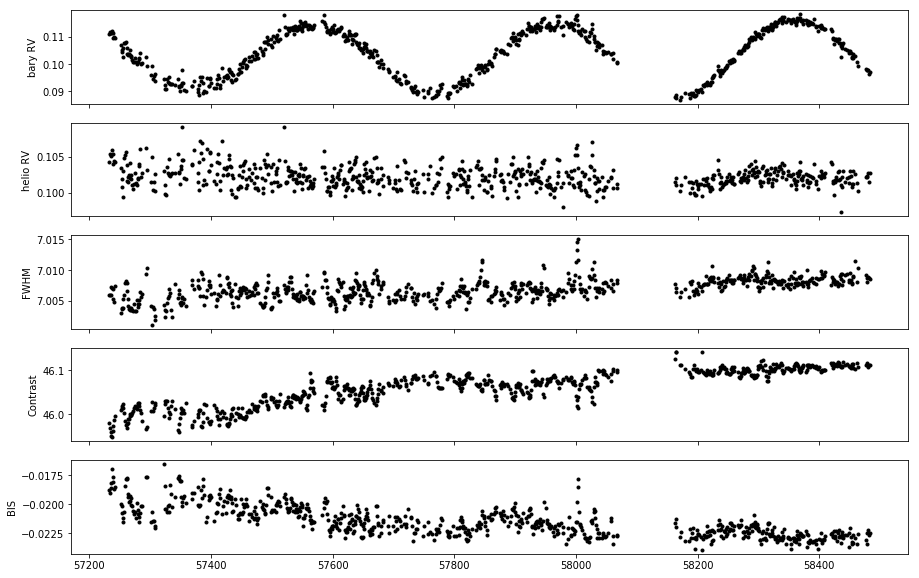

In [16]:
fig, axes = plt.subplots(5,1,figsize=(15,10),sharex=True)
axes[0].plot(bjd,rvb,'k.')
axes[1].plot(bjd,rvh,'k.')
axes[2].plot(bjd,fwhm,'k.')
axes[3].plot(bjd,cont,'k.')
axes[4].plot(bjd,bis,'k.')
axes[0].set_ylabel('bary RV')
axes[1].set_ylabel('helio RV')
axes[2].set_ylabel('FWHM')
#axes[2].set_ylim(6.98,7.02)
axes[3].set_ylabel('Contrast')
#axes[3].set_ylim(45.5,46.5)
axes[4].set_ylabel('BIS');
#axes[4].set_ylim(-0.03,-0.01);

Plot average daily heliocentric RVs corrected for bad weather and differential extinction.

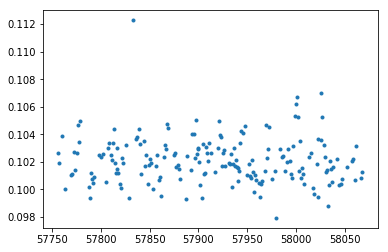

In [40]:
plt.plot(bjd,rvh,'.')

Plot average daily barycentric RVs corrected for bad weather and differential extinction.

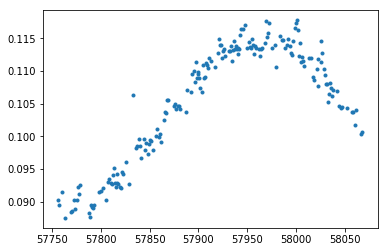

In [41]:
plt.plot(bjd,rvb,'.')

In [42]:
d0 = ccfRef
dmin,dmax = d0.min(),d0.max()
x1 = (d0-dmin)/(dmax-dmin)
d0p = np.append(d0[1:]-d0[:-1],0)
dmin,dmax = d0p.min(),d0p.max()
x2 = (d0p-dmin)/(dmax-dmin)
d0pp = np.append(0,d0p[1:]-d0p[:-1])
dmin,dmax = d0pp.min(),d0pp.max()
x3 = (d0pp-dmin)/(dmax-dmin)

In [43]:
from scipy.optimize import minimize
p1 = np.zeros((len(bjd),4))
ccfMod = np.zeros_like(ccfYear)
ccfMod1 = np.zeros_like(ccfYear)
ccfMod2 = np.zeros_like(ccfYear)
coeffs = np.zeros((len(bjd),4))
for i in range(len(bjd)):
    d = ccfYear[i,:].flatten()
    y = d - d0
    def model(p):
        m = p[0] + p[1] * x1 + p[2] * x2 + p[3] * x3
        return m
    def nll(p,y):
        m = model(p)
        return ((y-m)**2).sum()
    p0 = np.zeros(4)
    soln = minimize(nll,p0,args=(y))
    p1[i,:] = soln.x
    ccfMod[i,:] = model(soln.x)
    pp = np.copy(soln.x)
    pp[0] = 0
    pp[2] = 0
    ccfMod1[i,:] = model(pp)
    pp = np.copy(soln.x)
    pp[1] = 0
    pp[3] = 0
    ccfMod2[i,:] = model(pp)

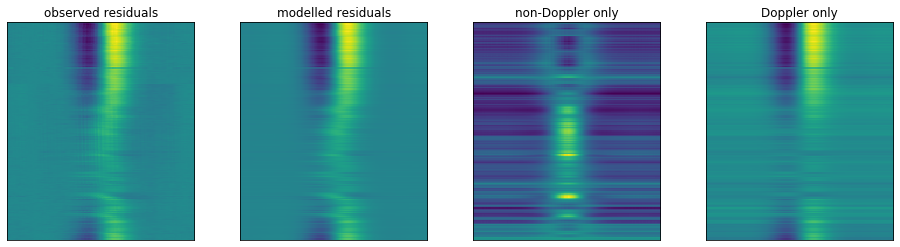

In [44]:
fig,axes=plt.subplots(1,4,sharex=True,figsize = (16,4))
axes[0].imshow(ccfYear - ccfRef)
axes[1].imshow(ccfMod)
axes[2].imshow(ccfMod1)
axes[3].imshow(ccfMod2)
axes[0].xaxis.set_visible(False) 
axes[0].yaxis.set_visible(False) 
axes[1].xaxis.set_visible(False) 
axes[1].yaxis.set_visible(False) 
axes[2].xaxis.set_visible(False) 
axes[2].yaxis.set_visible(False) 
axes[3].xaxis.set_visible(False) 
axes[3].yaxis.set_visible(False) 
axes[0].set_title('observed residuals')
axes[1].set_title('modelled residuals')
axes[2].set_title('non-Doppler only')
axes[3].set_title('Doppler only')
plt.savefig('diff_ccf.png')

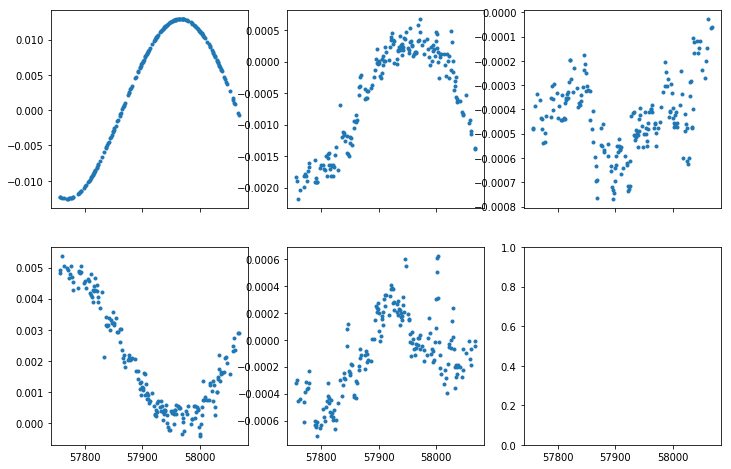

In [46]:
fig,axes=plt.subplots(2,3,sharex=True,figsize = (12,8))
rvpl = rvb-rvh
axes[0,0].plot(bjd,rvpl,'.')
axes[0,1].plot(bjd,p1[:,0].flatten(),'.')
axes[0,2].plot(bjd,p1[:,1].flatten(),'.')
axes[1,0].plot(bjd,p1[:,2].flatten(),'.')
axes[1,1].plot(bjd,p1[:,3].flatten(),'.')
